# Figure 2B and 2D

In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
covViral = pd.read_csv('stats/VeroInf24h.viral_genome.coverage.txt', sep='\t', names=['chrom', 'pos', 'count'])

In [3]:
covIVT = pd.read_csv('stats/IVT1.viral_genome.coverage.txt', sep='\t', names=['chrom', 'pos', 'count'])

In [4]:
covDNB = pd.read_csv('mgiseq/tables/VeroSCV2.virus.coverage.txt', sep='\t',names=['chrom', 'pos', 'count'])

In [5]:
anno = pd.read_csv('refs/SARS-CoV-2-annotations.gff', sep='\t', names=['chrom', 'type', 'name', 'start', 'end', 'x', 'y', 'z'])

In [6]:
orfcolors = pd.read_csv('colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [7]:
cdsanno = anno[anno['type'] == 'CDS']
cdsanno = cdsanno.iloc[:10].sort_values(by='start').iloc[:9]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['chrSCV', 'CDS', 'ORF1a', 266, 13468, '.', '.', '.'], index=cdsanno.columns),
        pd.Series(['chrSCV', 'CDS', 'ORF1b', 13468, 21552, '.', '.', '.'], index=cdsanno.columns),
    ])])
cdsanno = cdsanno.sort_values(by='start').iloc[:, 2:5].reset_index(drop=True)
cdsanno['color'] = cdsanno['name'].apply(orfcolors.__getitem__)
cdsanno.to_pickle('tmp/cdsannotation.pickle')
cdsanno

,name,start,end,color
0,ORF1a,266,13468,#c5d9ea
1,ORF1b,13468,21552,#e8d2c4
2,S,21563,25384,#82c91e
3,ORF3a,25393,26220,#3bc9db
4,E,26245,26472,#228be6
5,M,26523,27191,#9fb1fc
6,ORF6,27202,27387,#7950f2
7,ORF7a,27394,27759,#da77f2
8,ORF7b,27756,27887,#e64980
9,ORF8,27894,28259,#fd7e14


In [8]:
import matplotlib as mpl

In [9]:
covDNB['count'].max()

28008400.0

### Wide view panels

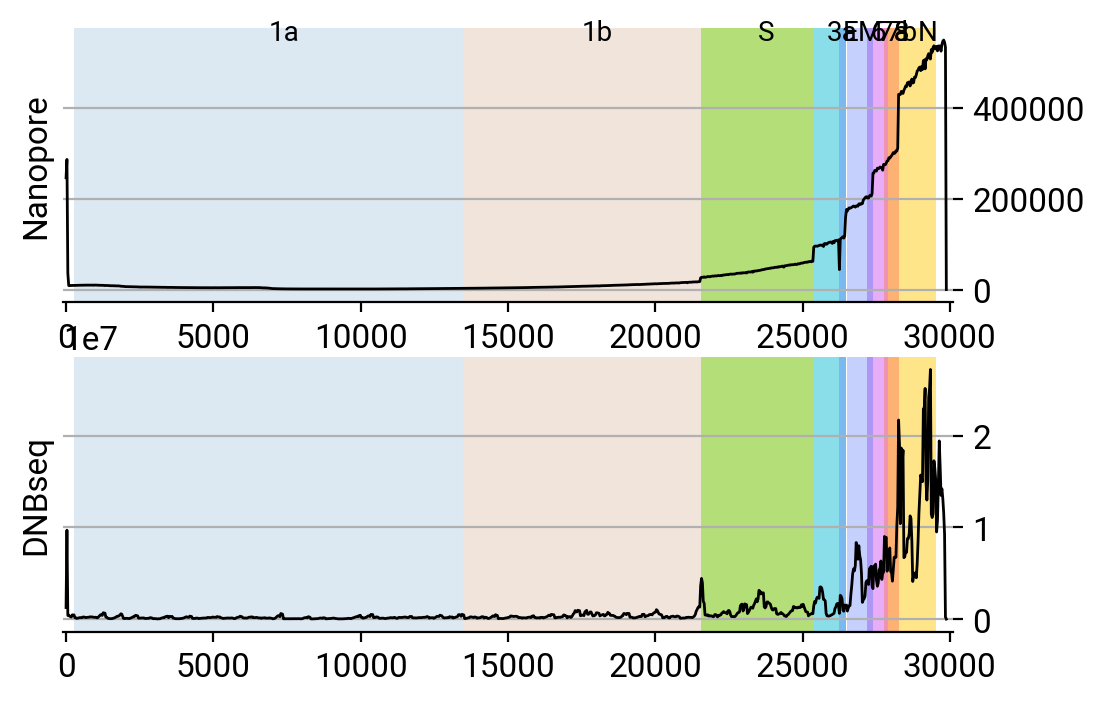

In [10]:
STRIDESIZE = 30

mpl.rcParams['ytick.labelright'] = True
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.left'] = False

def plot_hist(ax, data, title):
    data = data.copy()
    data['binpos'] = np.floor(data['pos'] / STRIDESIZE).astype(int) * STRIDESIZE
    medcov = data.groupby('binpos').agg({'count': 'median'})

    #ax.fill_between(medcov.index, 0, medcov['count'].tolist())
    ax.plot(medcov.index, medcov['count'].tolist(), c='black', lw=1)
    ax.set_xlim(-100, 30100)
    ax.set_ylabel(title)

    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.6, zorder=1)
        if ax is axes[0]:
            ax.annotate(row['name'].replace('ORF', ''),
                        ((row['start'] + row['end'])/2, medcov['count'].max()),
                        fontsize=10)

    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)
    
    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)

fig, axes = plt.subplots(2, 1, figsize=(5.74, 4))
plot_hist(axes[0], covViral, 'Nanopore')
plot_hist(axes[1], covDNB, 'DNBseq')
plt.savefig('figure-outputs/readdepth.pdf')

### Insets

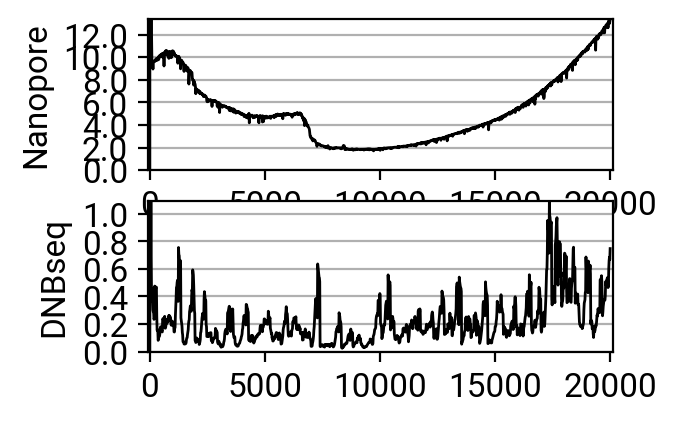

In [11]:
STRIDESIZE = 15

mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.left'] = True

RIGHTEND = 20000
IGNOREFIRST_FORYMAX = 100

def plot_hist(ax, data, title, xticks, yticks):
    data = data.copy()
    data['binpos'] = np.floor(data['pos'] / STRIDESIZE).astype(int) * STRIDESIZE
    medcov = data.groupby('binpos').agg({'count': 'median'})
    medcov = medcov[medcov.index.to_series().between(0, RIGHTEND)]
    
    medcov_noleader = medcov[medcov.index.to_series() >= IGNOREFIRST_FORYMAX]

    #ax.fill_between(medcov.index, 0, medcov['count'].tolist())
    ax.plot(medcov.index, medcov['count'].tolist(), c='black', lw=1)
    ax.set_xlim(-100, RIGHTEND+100)
    ax.set_ylim(0, medcov_noleader['count'].max())
    ax.set_ylabel(title)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    if np.max(yticks) >= 1000000:
        ax.set_yticklabels(yticks / 1000000)
    elif np.max(yticks) >= 1000:
        ax.set_yticklabels(yticks / 1000)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)

fig, axes = plt.subplots(2, 1, figsize=(3, 2.2))
plot_hist(axes[0], covViral, 'Nanopore', np.arange(0, 20001, 5000), np.arange(0, 12001, 2000))
plot_hist(axes[1], covDNB, 'DNBseq', np.arange(0, 20001, 5000), np.arange(0, 1000001, 200000))
plt.savefig('figure-outputs/readdepth-detailed.pdf')